# Sample script for RNN VAE model

### imports

In [1]:
%matplotlib inline

from torch.autograd import Variable
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../Modules")
sys.path.append("../ToyDatasets")

# local imports
from helpers import kl_loss
from visualize import plotSamples
from models import RNNVAE
from timeSeries import Sinusoids

## Define dataset loader

In [2]:
batch_size = 256
num_steps = 16
dataset_size = 2000
num_classes = 10

data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),batch_size=batch_size,shuffle=True)

batch_loader = iter(data_loader)

## Define and load model

In [3]:
model = RNNVAE(input_size=1,rnn_size=256,latent_size=64,output_size=num_classes,use_softmax=True)
model.eval()
model.load_state_dict(torch.load("Saved_models/RNNVAE_nll.pt"))

## Collect some samples and plot

In [4]:
def sampleCompare(batch_loader,model):
    sampled_data = {"x":[],"recon_x":[]}
    try:
        batch = next(batch_loader)
    except StopIteration:
        batch_loader = iter(data_loader)
        batch = next(batch_loader)
    x = Variable(batch).type(torch.FloatTensor).transpose(1,0)
    size = (x.size()[1],model.samplelayer.outputShape()[-1])
    z = Variable(torch.FloatTensor(*size).normal_(),requires_grad=False)
    recon_x = model.sample(z,num_steps=x.size()[0])
    _,topi = recon_x.data.topk(1)
    pred_x = Variable(topi)
    sampled_data["x"] = x.squeeze(2)
    sampled_data["recon_x"] = pred_x.squeeze(2)
    plotSamples(sampled_data["x"],xu=num_steps,yu=num_classes)
    plotSamples(sampled_data["recon_x"],xu=num_steps,yu=num_classes)

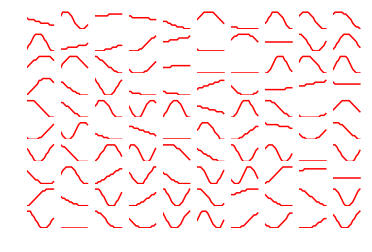

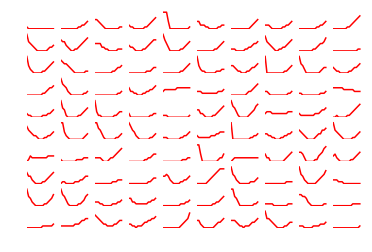

In [5]:
sampleCompare(batch_loader,model)

In [6]:
model2dLatent = RNNVAE(input_size=1,rnn_size=256,latent_size=2,output_size=num_classes,use_softmax=True)
model2dLatent.eval()
model2dLatent.load_state_dict(torch.load("Saved_models/CNNVAE_nll_2d_latent.pt"))

In [7]:
def sampleFromLatent(model,std,num_samples,num_steps):
    grid_x = np.linspace(-std,std,num_samples)
    grid_y = np.linspace(-std,std,num_samples)
    z_numpy = np.zeros((num_samples**2,2))
    sample_nb = 0
    for x in grid_x:
        for y in grid_y:
            z_numpy[sample_nb,0] = x
            z_numpy[sample_nb,1] = y
            sample_nb += 1
    z = Variable(torch.from_numpy(z_numpy)).type(torch.FloatTensor)
    recon_x = model.sample(z,num_steps)
    _,topi = recon_x.data.topk(1)
    pred_x = Variable(topi).squeeze(2)
    plotSamples(pred_x,xu=num_steps,yu=num_classes)

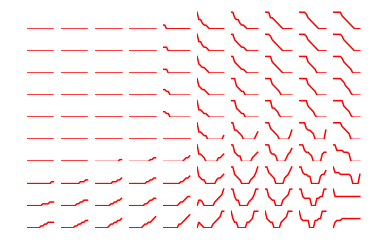

In [8]:
sampleFromLatent(model2dLatent,3,10,16)